In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##2. 시맨틱 세그멘테이션 데이터셋

###이미지, 데이터 가져오기

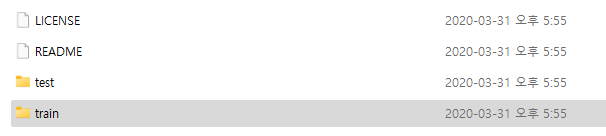
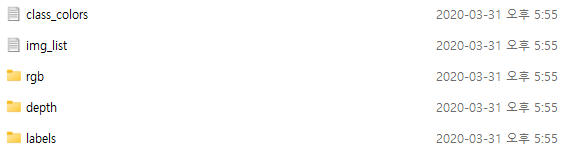

In [2]:
#KITTI데이터셋의 세그멘테이션 데이터 다운로드 (Ivan Kreso가 도로영역 라벨링함)
#https://www.cvlibs.net/datasets/kitti/eval_semantics.php
#https://www.zemris.fer.hr/~ssegvic/multiclod/kitti_semseg_unizg.shtml #Ivan Kreso #KITTI-SEMSEG-UNIZG
# road 128 64 128

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data' # 경로 설정


###데이터 로더(data loader) 만들기<br>


In [3]:
!pip list | grep albumentations

albumentations                   1.3.1


In [4]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [5]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [6]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/' # 경로 설정

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(len(input_images)):  # 리스트의 실제 크기에 맞춰 루프 범위를 조정
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

<Figure size 1200x2000 with 0 Axes>

In [7]:
class KittiGenerator(tf.keras.utils.Sequence):


  def __init__(self, dir_path, batch_size=16, img_size=(224, 224, 3),
               output_size=(224, 224), is_train=True, augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size
    self.data = self.load_dataset()  # 데이터셋을 로드합니다.

  def load_dataset(self):
    '''
    데이터셋을 로드하는 함수입니다. 이미지와 라벨의 경로를 로드하고 정렬합니다.
    '''
    # 입력 이미지와 라벨 이미지의 경로를 가져옵니다.
    #/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/train/rgb
    #/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/train/labels
    input_images = glob(os.path.join(self.dir_path, "train/rgb", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "train/labels", "*.png"))
    # 두 리스트를 정렬하여 각 입력 이미지가 해당 라벨과 일치하도록 합니다.
    input_images.sort()
    label_images.sort()
    # 입력과 라벨 이미지의 수가 동일한지 확인합니다.
    assert len(input_images) == len(label_images)
    # 이미지 경로와 라벨 경로를 튜플로 묶어 리스트에 저장합니다.
    data = [ _ for _ in zip(input_images, label_images)]

    # 훈련 데이터의 경우 마지막 30개를 제외한 모든 데이터를 사용합니다.
    if self.is_train:
      return data[:-30]
    # 테스트 데이터의 경우 마지막 30개만 사용합니다.
    return data[-30:]

  def __len__(self):
    '''
    데이터 생성기의 길이를 반환합니다. 이는 전체 데이터셋을 배치 크기로 나눈 값의 올림과 같습니다.
    '''
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    '''
    주어진 인덱스에 해당하는 배치를 생성하여 반환합니다.
    '''
    # 지정된 인덱스에 해당하는 배치의 데이터를 가져옵니다.
    batch_data = self.data[index*self.batch_size:(index + 1)*self.batch_size]
    # 입력 데이터와 라벨 데이터를 저장할 배열을 준비합니다.
    inputs = np.zeros([self.batch_size, *self.img_size[:2], self.img_size[2]])  # (배치 크기, 높이, 너비, 채널)
    outputs = np.zeros([self.batch_size, *self.output_size[:2]])  # (배치 크기, 높이, 너비)

    # 배치 데이터에 대해 반복하여 입력과 출력 데이터를 처리합니다.
    for i, data in enumerate(batch_data):
        input_img_path, output_path = data
        _input = imread(input_img_path)
        _output = imread(output_path)
        # augmentation을 적용합니다.
        augmented = self.augmentation(image=_input, mask=_output)
        # 처리된 이미지와 라벨을 배치 데이터 배열에 저장합니다.
        inputs[i] = augmented['image'] / 255  # 이미지 데이터 추출 및 정규화
        outputs[i] = augmented['mask'][:,:,0]  # 라벨 데이터의 첫 번째 채널만 추출

    return inputs, outputs


In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

##3. 시맨틱 세그멘테이션 모델

###모델 구조 만들기<br>


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def build_model(input_shape=(224, 224, 3)):
    # 모델 구축 함수를 정의합니다. 기본적인 U-Net 구조를 따릅니다.

    # 입력 레이어를 정의합니다. input_shape는 모델이 기대하는 입력 데이터의 형태를 결정합니다.
    inputs = Input(input_shape)

    # 인코더 시작: 이미지의 특징을 추출하는 컨볼루션 레이어들을 정의합니다.
    # Conv2D 레이어는 이미지에 대해 컨볼루션 연산을 수행합니다. 64개의 필터를 사용하고, 커널 크기는 3x3입니다.
    # 'relu'는 비선형 활성화 함수입니다. 'padding=same'은 입력과 출력의 크기를 같게 유지합니다.
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    # MaxPooling2D 레이어는 이미지의 크기를 줄이면서 중요한 특징을 유지합니다.
    pool1 = MaxPooling2D((2, 2))(conv1)

    # 두 번째 컨볼루션 블록. 필터의 수를 두 배로 늘려 더 복잡한 특징을 추출합니다.
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)



    # 디코더 시작: 인코더를 통해 얻은 특징을 사용하여 이미지의 크기를 원본으로 복원합니다.
    # UpSampling2D는 이미지의 크기를 늘립니다. 여기서는 크기를 두 배로 늘립니다.
    up1 = UpSampling2D((2, 2))(pool2)
    # 컨볼루션 레이어를 사용하여 늘어난 이미지에 다시 특징을 추가합니다.
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

    # 이미지의 크기를 다시 두 배로 늘립니다.
    up2 = UpSampling2D((2, 2))(conv3)
    # 마지막 컨볼루션 레이어를 추가합니다.
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    # 최종 출력 레이어를 추가합니다.
    # 1x1 컨볼루션을 사용하여 최종적으로 원하는 채널 수로 특징 맵을 조정합니다.
    # 여기서는 1개의 출력 채널을 가지며, 'sigmoid' 활성화 함수를 사용하여 이진 분류 문제에 적합한 출력을 생성합니다.
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    # 입력과 출력을 연결하여 최종 모델을 정의합니다.
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
    # 함수를 호출하면 위에서 정의한 구조의 신경망 모델을 반환합니다.


###모델 학습하기<br>


In [11]:
model_path = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=20,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/20
24/24 [==============================] - 16s 503ms/step - loss: -74.1777 - val_loss: -359.5092
Epoch 2/20
24/24 [==============================] - 13s 530ms/step - loss: -1239.2911 - val_loss: -1550.0952
Epoch 3/20
24/24 [==============================] - 13s 523ms/step - loss: -1581.6356 - val_loss: -1551.1375
Epoch 4/20
24/24 [==============================] - 13s 528ms/step - loss: -1588.0931 - val_loss: -1551.1683
Epoch 5/20
24/24 [==============================] - 13s 510ms/step - loss: -1600.2227 - val_loss: -1551.1753
Epoch 6/20
24/24 [==============================] - 13s 530ms/step - loss: -1585.6791 - val_loss: -1551.1777
Epoch 7/20
24/24 [==============================] - 14s 549ms/step - loss: -1585.4865 - val_loss: -1551.1799
Epoch 8/20
24/24 [==============================] - 13s 532ms/step - loss: -1586.9486 - val_loss: -1551.1807
Epoch 9/20
24/24 [==============================] - 12s 496ms/step - loss: -1590.3872 - val_loss: -1551.1812
Epoch 10/20
24/24 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##4. 시맨틱 세그멘테이션 모델 시각화

In [12]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
# model_path = dir_path + '/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

In [13]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [14]:
import os
from PIL import Image  # 이미지 처리 라이브러리 사용 예시

dir_path = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/train/rgb'
output_dir = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/train/result'

# 디렉토리 내 모든 파일 목록을 얻습니다.
file_list = os.listdir(dir_path)

# 이미지 파일의 확장자를 지정합니다. 예를 들어 '.png' 또는 '.jpg' 등
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp']  # 이미지 확장자 리스트를 수정해주세요.

# 이미지 파일만 처리하는 for 루프를 실행합니다.
for filename in file_list:
    # 파일의 확장자를 소문자로 변환한 뒤 확인합니다.
    file_extension = os.path.splitext(filename)[-1].lower()
    if file_extension in image_extensions:
        # 이미지 파일일 경우에만 작업을 수행합니다.
        image_path = os.path.join(dir_path, filename)
        output_filename = f'result_{filename}'  # 결과 파일명을 설정합니다.
        output_path = os.path.join(output_dir, output_filename)

        # 이제 image_path를 이용하여 모델에 입력하고 결과를 output_path에 저장하는 작업을 수행하세요.
        # 예를 들어, 이미지를 열고 저장하는 코드는 다음과 같을 수 있습니다.
        img = Image.open(image_path)
        # 모델에 이미지를 입력하고 결과를 얻는 코드를 추가하세요.

        # 결과 이미지를 저장합니다.
        img.save(output_path)




In [15]:
import os

dir_path = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/train/result'

# 이미지 파일 리스트 생성
image_files = [f for f in os.listdir(dir_path) if f.endswith('.png')]

for i, image_file in enumerate(image_files):
    image_path = os.path.join(dir_path, image_file)
    output_path = os.path.join(dir_path, f'result_{str(i).zfill(3)}.png')

    get_output(
         model,
         test_preproc,
         image_path=image_path,
         output_path=output_path
    )



In [16]:
def calculate_iou_score(target, prediction):
    # Intersection 계산
    intersection = np.logical_and(target, prediction).sum()

    # Union 계산
    union = np.logical_or(target, prediction).sum()

    # IoU 스코어 계산 (0으로 나누는 것을 방지하기 위해 예외 처리)
    iou_score = intersection / (union + 1e-5)

    print('IoU : %f' % iou_score)

    return iou_score


In [17]:
!pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.2.0 which is incompatible.


In [18]:
# Pillow 최신 버전 설치 (필요한 경우)
!pip install --upgrade Pillow

from PIL import Image
import numpy as np

def get_output(model, preproc, image_path, output_path, label_path):
    # 이미지 읽기 (16비트 이미지를 제대로 처리하기 위해 수정)
    origin_img = Image.open(image_path).convert('RGB')  # RGB로 변환
    data = {"image": np.array(origin_img)}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    output = (output[0].numpy() >= 0.5).astype(np.uint8).squeeze(-1) * 255
    prediction = output / 255

    output_img = Image.fromarray(output)
    background = origin_img.convert('RGBA')
    output_img = output_img.resize((origin_img.size[0], origin_img.size[1])).convert('RGBA')
    output_img = Image.blend(background, output_img, alpha=0.5)
    output_img.show()

    if label_path:
        label_img = Image.open(label_path).convert('L')  # 그레이스케일 변환
        label_data = {"image": np.array(label_img)}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)

        return output_img, prediction, target
    else:
        return output_img, prediction, None


In [19]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/aiffel/CV/semantic_segmentation/data/train/'

def create_file_path(dir_path, file_type, series, i):
    file_number = f"{series}_{str(i).zfill(6)}"
    if file_type == 'image':
        return f'{dir_path}result/result_{file_number}.png'
    elif file_type == 'output':
        return f'{dir_path}result/result_{file_number}.png'
    elif file_type == 'label':
        # 'depth' 폴더 대신 'labels' 폴더를 사용
        return f'{dir_path}labels/{file_number}.png'

# 시리즈 번호와 이미지 번호를 변수로 사용
series_number = '00'
image_number = 540  # 혹은 원하는 다른 번호로 변경 가능

image_path = create_file_path(dir_path, 'image', series_number, image_number)
output_path = create_file_path(dir_path, 'output', series_number, image_number)
label_path = create_file_path(dir_path, 'label', series_number, image_number)

output, prediction, target = get_output(model, test_preproc, image_path, output_path, label_path)
iou_score = calculate_iou_score(target, prediction)
print(f"IOU Score: {iou_score}")


IoU : 0.000140
IOU Score: 0.00013950892854362463


###회고:

epochs=20으로 설정한 결과<br>IoU : 0.000140,
IOU Score: 0.00013950892854362463이 나왔다.<br>이것은 매우 낮은 성능을 의미하고 있다.<br>애초에 100으로 epoch을 설정한 이유가 있는 것 같다. 이러한 결과는 모델이 타겟 객체를 거의 탐지하지 못했거나, 완전히 잘못 탐지했다는 것을 의미한다. <br>낮은 결과값의 전반적인 원인들은<br>1.데이터 처리의 문제: 입력 데이터가 적절히 처리되지 않았거나, 라벨링에 오류가 있을 수 있다.<br>2.
모델 구조의 부적절함: 사용된 모델이 특정 데이터셋에 적합하지 않거나, 충분히 학습되지 않았을 가능성이 있다.<br>3.
하이퍼파라미터 설정의 문제: 학습률, 배치 크기, 에포크 수 등의 하이퍼파라미터 설정이 최적화되지 않았을 수 있다.<br>4.
과소적합 문제: 모델이 너무 단순하여 데이터의 복잡성을 충분히 학습하지 못했을 수 있다. 라고 생각해볼 수 있을 것 같다.